# Understanding attention in transformers

In [118]:
import torch
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt

%pip install -e .
from transformers.word_embedding import preprocess_text

/Users/juan.rodriguez/Desktop/Transformers/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


### Single head of attention

1. We embed our sentence in a high-dimensional vector space encoding the meaning of words and position

In [106]:
sentence = ["Let's make artificial intelligence quantum"]

preprocessed_sentences = [preprocess_text(sent) for sent in sentence]
model = Word2Vec(preprocessed_sentences, vector_size=50, min_count=1)
word_vectors = model.wv
word_vectors.vectors[0]  # Example: Get the vector for the first word

array([-1.0724545e-03,  4.7286271e-04,  1.0206699e-02,  1.8018546e-02,
       -1.8605899e-02, -1.4233618e-02,  1.2917745e-02,  1.7945977e-02,
       -1.0030856e-02, -7.5267432e-03,  1.4761009e-02, -3.0669428e-03,
       -9.0732267e-03,  1.3108104e-02, -9.7203208e-03, -3.6320353e-03,
        5.7531595e-03,  1.9837476e-03, -1.6570430e-02, -1.8897636e-02,
        1.4623532e-02,  1.0140524e-02,  1.3515387e-02,  1.5257311e-03,
        1.2701781e-02, -6.8107317e-03, -1.8928028e-03,  1.1537147e-02,
       -1.5043275e-02, -7.8722071e-03, -1.5023164e-02, -1.8600845e-03,
        1.9076237e-02, -1.4638334e-02, -4.6675373e-03, -3.8754821e-03,
        1.6154874e-02, -1.1861792e-02,  9.0324880e-05, -9.5074680e-03,
       -1.9207101e-02,  1.0014586e-02, -1.7519170e-02, -8.7836506e-03,
       -7.0199967e-05, -5.9236289e-04, -1.5322480e-02,  1.9229487e-02,
        9.9641159e-03,  1.8466286e-02], dtype=float32)

In [108]:
batch_size = 1
seq_len = len(preprocessed_sentences[0])
emb_dim = word_vectors.vectors.shape[1]

Wq = torch.randn(emb_dim, emb_dim)
Wk = torch.randn(emb_dim, emb_dim)
Wv = torch.randn(emb_dim, emb_dim)

X = torch.tensor([word_vectors.vectors])

Q = torch.matmul(X, Wq)  # (batch_size, seq_len, emb_dim)
K = torch.matmul(X, Wk)  # (batch_size, seq_len, emb_dim)
V = torch.matmul(X, Wv)  # (batch_size, seq_len, emb_dim)

Q.shape

torch.Size([1, 5, 50])

Dot product of query and key matrices and normalization

In [109]:
scores = torch.matmul(Q, K.transpose(-2, -1)) / emb_dim**0.5
scores.shape

torch.Size([1, 5, 5])

Softmax

In [110]:
attn_weights = torch.softmax(scores, dim=-1)
print([sum(attn_weights[0][i]) for i in range(seq_len)])  # each row sums to 1

[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.0000)]


In [117]:
attn_weights

tensor([[[0.2010, 0.1995, 0.2002, 0.1991, 0.2002],
         [0.2009, 0.2000, 0.1991, 0.1988, 0.2012],
         [0.1998, 0.1993, 0.2021, 0.1999, 0.1989],
         [0.1989, 0.1994, 0.1997, 0.2005, 0.2015],
         [0.1991, 0.1993, 0.2000, 0.2002, 0.2013]]])

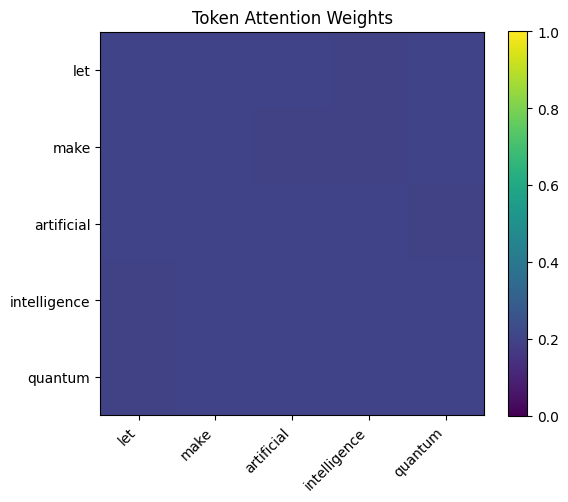

In [136]:
plt.figure(figsize=(max(6, seq_len * 0.7), max(5, seq_len * 0.6)))
plt.imshow(attn_weights.detach().numpy()[0], vmin=0, vmax=1)
plt.xticks(range(seq_len), preprocessed_sentences[0], rotation=45, ha="right")
plt.yticks(range(seq_len), preprocessed_sentences[0])
plt.colorbar()
plt.title("Token Attention Weights")
plt.tight_layout()
plt.show()

Multiply by the value vector

In [137]:
att_pattern = torch.matmul(attn_weights, V)
att_pattern.shape

torch.Size([1, 5, 50])

### Multi-head attention